In [24]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
import copy
from typing import Tuple, Any, Optional, Union, List
from collections import Counter
import random
import math
import re

In [3]:
# load data
drive.mount('/content/drive')
datapath = "/content/drive/MyDrive/csc311_project/cleaned_data_combined_modified.csv"
df = pd.read_csv(datapath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head()

,id,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q3: In what setting would you expect this food to be served? Please check all that apply,Q4: How much would you expect to pay for one serving of this food item?,Q5: What movie do you think of when thinking of this food item?,Q6: What drink would you pair with this food item?,"Q7: When you think about this food item, who does it remind you of?",Q8: How much hot sauce would you add to this food item?,Label
0,716549,3,6,"Week day lunch,At a party,Late night snack",5,Cloudy with a Chance of Meatballs,Coke,Friends,A little (mild),Pizza
1,715742,4,"bread, meet","Week day lunch,At a party,Late night snack",5$ for a large piece,All sort of american young boy movies,Coke,"Friends,Teachers,Strangers",NaN,Pizza
2,727333,3,5,"Week day lunch,Week day dinner,Weekend lunch,W...",10dollar,action movie,cola,Friends,A moderate amount (medium),Pizza
3,606874,4,6-7,"Week day lunch,Week day dinner,Weekend lunch,W...",$3,Mamma Mia,Soda,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3 or more,"Week day lunch,Week day dinner,Weekend lunch,W...",$5,Cloudy with a chance of meatballs,Soda,"Siblings,Friends",A little (mild),Pizza


Let's look at the questions for which there are a limited set of answers

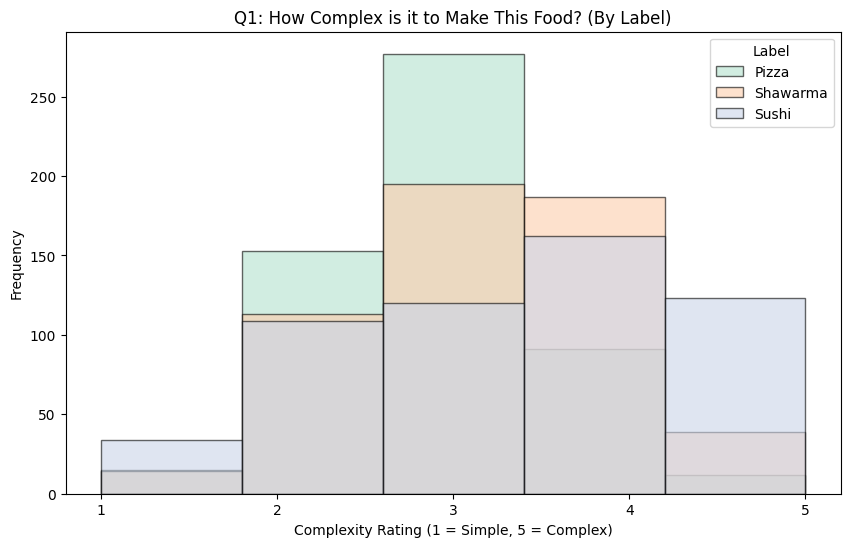

In [60]:
q1 = df[['Label', 'Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)']]
plt.figure(figsize=(10,6))

labels = q1['Label'].unique()
colors = plt.cm.Pastel2.colors

for i, label in enumerate(labels):
    subset = q1[q1['Label'] == label]
    plt.hist(subset.iloc[:, 1], bins=5, alpha=0.6, label=label, color=colors[i % len(colors)], edgecolor="black")

plt.xlabel("Complexity Rating (1 = Simple, 5 = Complex)")
plt.ylabel("Frequency")
plt.title("Q1: How Complex is it to Make This Food? (By Label)")
plt.legend(title="Label")
plt.xticks(range(1, 6))

plt.show()

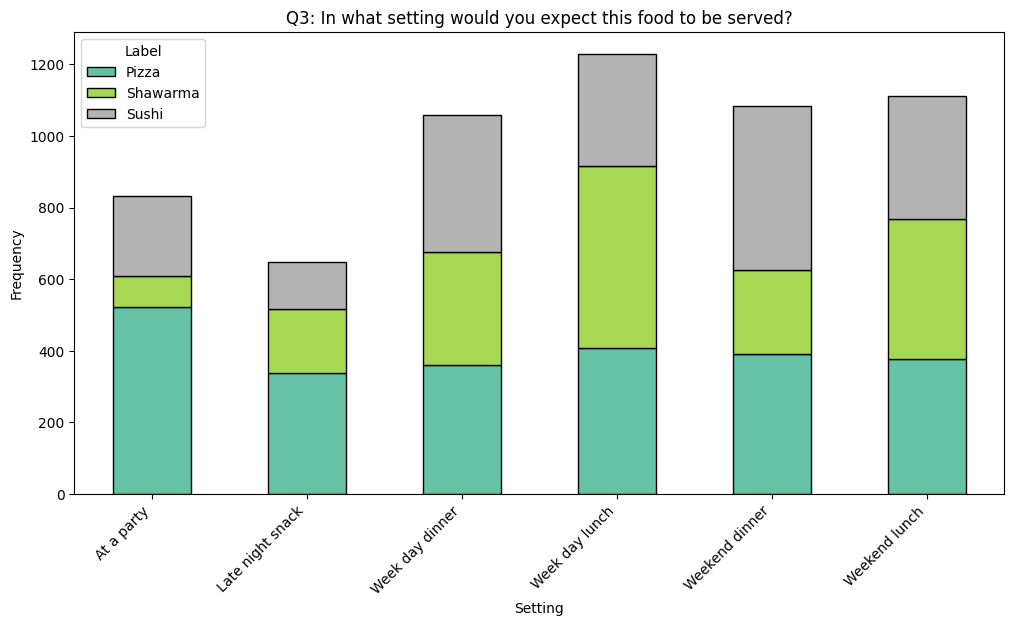

In [59]:
q3_xpo = df[['Label', 'Q3: In what setting would you expect this food to be served? Please check all that apply']].copy()
q3_xpo['Setting'] = q3_xpo['Q3: In what setting would you expect this food to be served? Please check all that apply'].str.split(',')
q3_xpo = q3_xpo.explode('Setting')

counts = q3_xpo.groupby(['Setting', 'Label']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2', edgecolor='black')

plt.xlabel("Setting")
plt.ylabel("Frequency")
plt.title("Q3: In what setting would you expect this food to be served?")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Label")

plt.show()

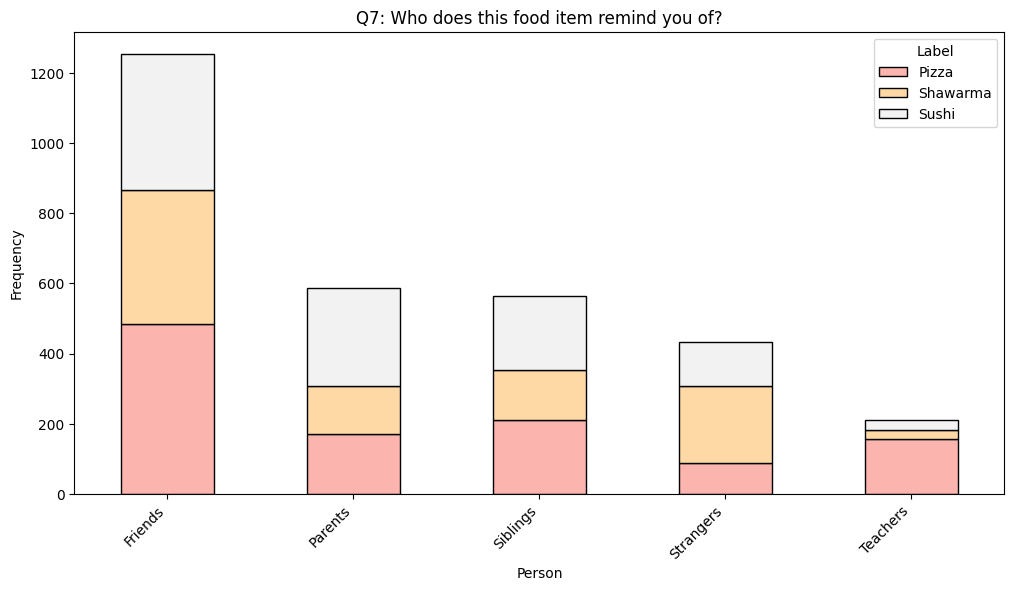

In [57]:
q7_xpo = df[['Label', 'Q7: When you think about this food item, who does it remind you of?']].copy()
q7_xpo['Person'] = q7_xpo['Q7: When you think about this food item, who does it remind you of?'].str.split(',')
q7_xpo = q7_xpo.explode('Person')

# occurrences grouped by Label & Person
counts = q7_xpo.groupby(['Person', 'Label']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Pastel1', edgecolor='black')

plt.xlabel("Person")
plt.ylabel("Frequency")
plt.title("Q7: Who does this food item remind you of?")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Label")

plt.show()

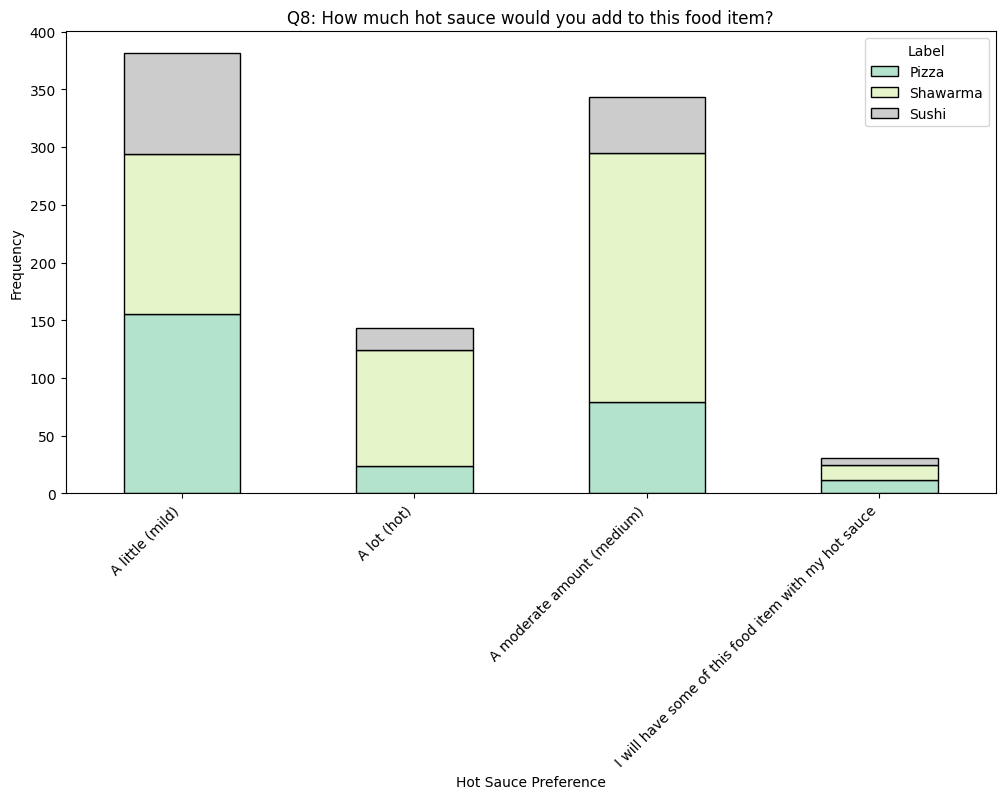

In [58]:
groups = df.groupby(["Q8: How much hot sauce would you add to this food item?", "Label"]).size().unstack(fill_value=0)
groups.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Pastel2', edgecolor='black')

plt.xlabel("Hot Sauce Preference")
plt.ylabel("Frequency")
plt.title("Q8: How much hot sauce would you add to this food item?")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label")

plt.show()

Interesting how the hot sauce is normally distributed. It would also be interesting to see the breakdown of words for each question. We will make a BOW matrix for each question and take a look at the word distributions for each question.

In [44]:
bow_df = copy.deepcopy(df)
text_cols = [
    "Q2: How many ingredients would you expect this food item to contain?",
    "Q4: How much would you expect to pay for one serving of this food item?",
    "Q5: What movie do you think of when thinking of this food item?",
    "Q6: What drink would you pair with this food item?",
]

for col in text_cols:
    bow_df[col] = bow_df[col].fillna("none").str.lower().str.strip()

def simple_bow(df, column_name, prefix):
    vocab = set()
    tokenized = []

    # tokenize and build vocab
    for text in df[column_name]:
        tokens = re.findall(r'\b\w+\b', text)
        tokenized.append(tokens)
        vocab.update(tokens)

    vocab = sorted(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}

    # create binary BoW matrix
    bow_matrix = np.zeros((len(df), len(vocab)), dtype=int)
    for i, tokens in enumerate(tokenized):
        for token in tokens:
            if token in vocab_index:
                bow_matrix[i, vocab_index[token]] = 1

    return pd.DataFrame(bow_matrix, columns=[f"{prefix}_{word}" for word in vocab])

# apply BoW to each column
bow_frames = []
for i, col in enumerate(text_cols):
    question_number = col.split(":")[0]
    bow_frames.append(simple_bow(bow_df, col, question_number))

bow_df = pd.concat([bow_df] + bow_frames, axis=1)
bow_df = bow_df.drop(columns=text_cols)
bow_df = bow_df.drop(columns=['id', 'Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)', 'Q3: In what setting would you expect this food to be served? Please check all that apply',
                              'Q7: When you think about this food item, who does it remind you of?', 'Q8: How much hot sauce would you add to this food item?'])
bow_df.head()

,Label,Q2_1,Q2_10,Q2_11,Q2_12,Q2_13,Q2_14,Q2_15,Q2_17,Q2_2,...,Q6_wines,Q6_with,Q6_works,Q6_would,Q6_wouldn,Q6_yakult,Q6_yogurt,Q6_you,Q6_yuzu,Q6_zero
0,Pizza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pizza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Pizza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Pizza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Pizza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
bow_df_melted = bow_df.melt(id_vars=["Label"], var_name="Q_word", value_name="count")
split_cols = bow_df_melted["Q_word"].str.split("_", n=1, expand=True)
bow_df_melted["Q"] = split_cols[0]
bow_df_melted["word"] = split_cols[1].fillna("Unknown")  # "Unknown" if no word exists
bow_df_melted.head()

,Label,Q_word,count,Q,word
0,Pizza,Q2_1,0,Q2,1
1,Pizza,Q2_1,0,Q2,1
2,Pizza,Q2_1,0,Q2,1
3,Pizza,Q2_1,0,Q2,1
4,Pizza,Q2_1,0,Q2,1


In [46]:
bow_df_grouped = bow_df_melted.groupby(["Label", "Q", "word"])["count"].sum().reset_index()
bow_df_grouped.head()

,Label,Q,word,count
0,Pizza,Q2,1,4
1,Pizza,Q2,10,63
2,Pizza,Q2,11,1
3,Pizza,Q2,12,4
4,Pizza,Q2,13,3


In [47]:
def top_words(df, question):
    """ Plot the top 15 words per question per label. """
    plt.figure(figsize=(12, 6))
    for label in df["Label"].unique():
        subset = df[(df["Q"] == question) & (df["Label"] == label)]
        top_words = subset.nlargest(15, "count")
        plt.barh(top_words["word"] + f" ({label})", top_words["count"], label=f"Label: {label}")

    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top 15 Words in {question}")
    plt.legend()
    plt.show()

In [48]:
bow_df_grouped['Q'].unique()

array(['Q2', 'Q4', 'Q5', 'Q6'], dtype=object)

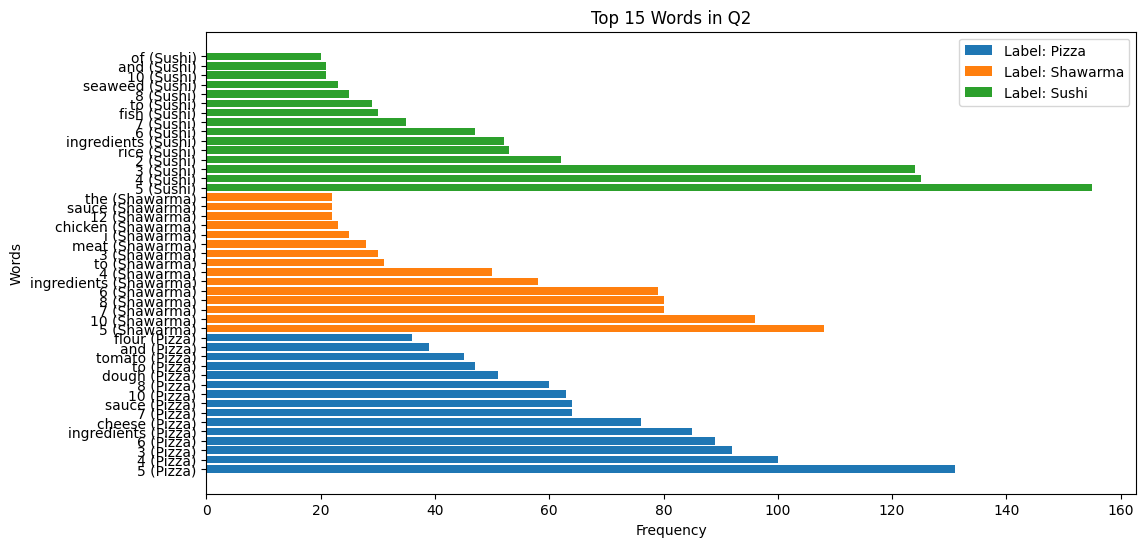

In [49]:
top_words(bow_df_grouped, "Q2")

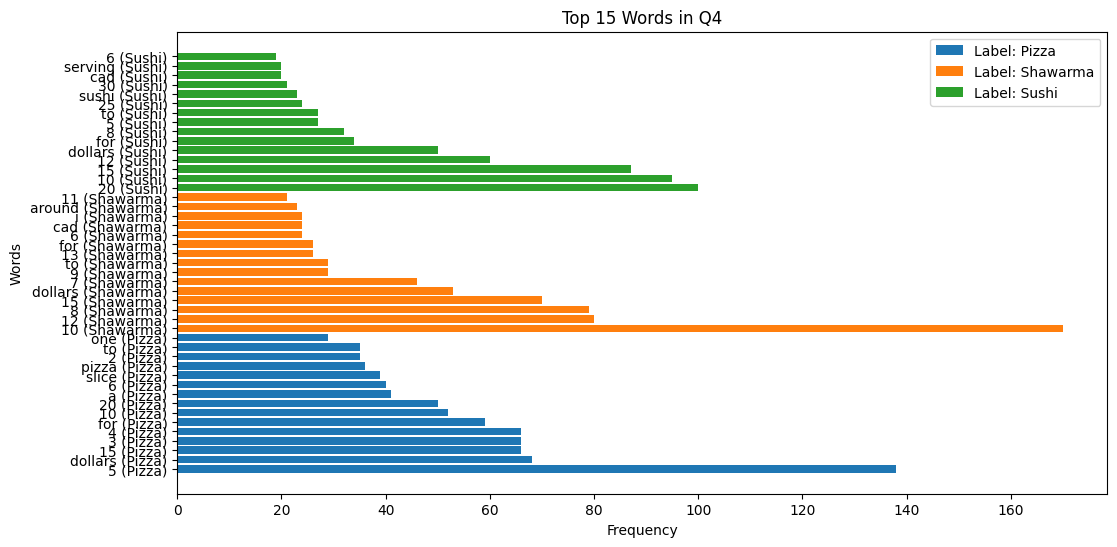

In [50]:
top_words(bow_df_grouped, "Q4")

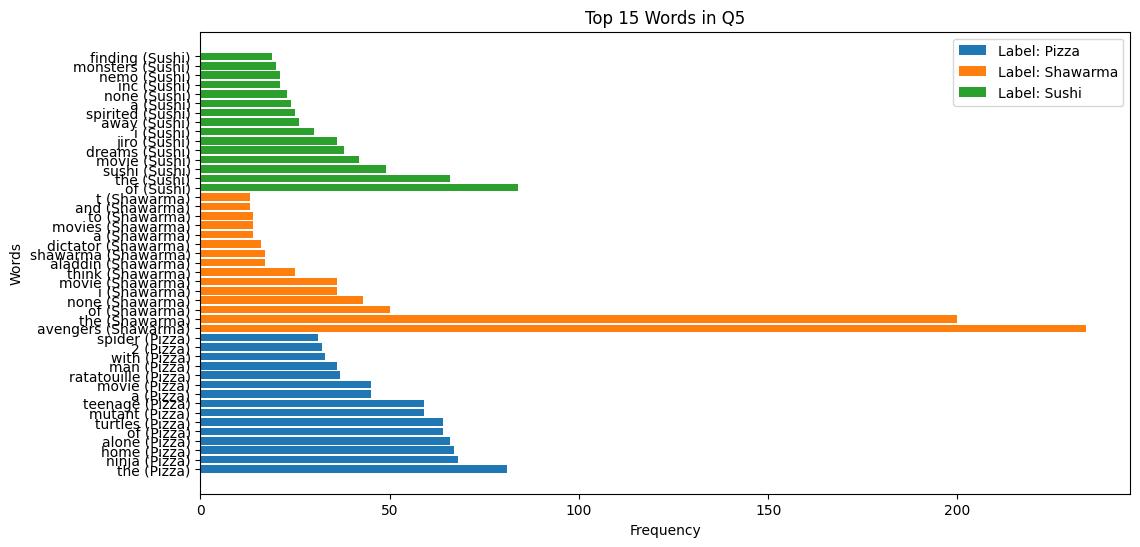

In [51]:
top_words(bow_df_grouped, "Q5")

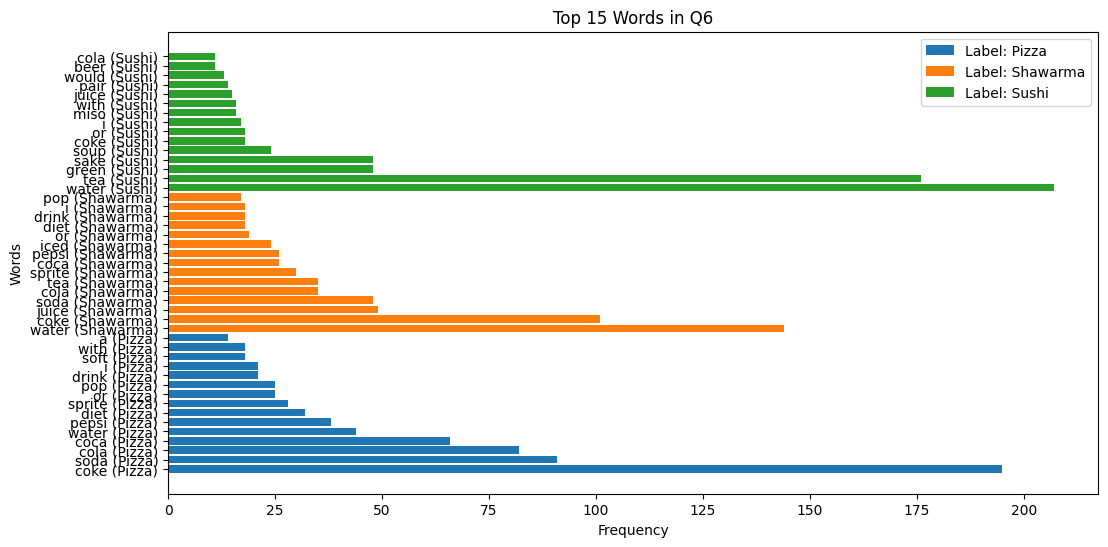

In [52]:
top_words(bow_df_grouped, "Q6")

Would also be interesting to see the average word counts overall for each question

In [64]:
def avg_wc(df, text_cols):
    """ Plot average number of words in responses for each question. """
    avg_word_counts = []

    for col in text_cols:
        word_counts = df[col].fillna("").apply(lambda x: len(x.split()))
        avg_word_counts.append(word_counts.mean())

    plt.figure(figsize=(10, 5))
    plt.bar(text_cols, avg_word_counts, color="skyblue", edgecolor="black")

    short_labels = [col[:2] for col in text_cols]

    plt.xlabel("Questions")
    plt.ylabel("Average Word Count")
    plt.title("Average Number of Words Per Response")
    plt.xticks(ticks=range(len(text_cols)), labels=short_labels, rotation=45, ha="right")

    for i, count in enumerate(avg_word_counts):
        plt.text(i, count + 0.2, f"{count:.1f}", ha='center', fontsize=10, fontweight="bold")

    plt.show()

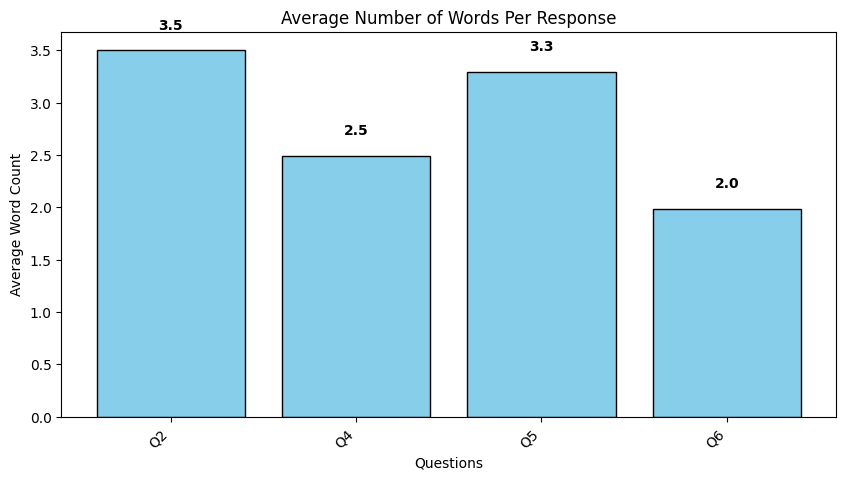

In [65]:
avg_wc(df, text_cols)